#Course work (Text analysis)

###Sentiment analysis of posts from the VK-group "Netfleet"

Моя работа заключается в анализе тональности постов в ВК-группе по водному транспорту. Парсила посты я локально в jupyter и выгрузила в csv файл.

In [1]:
!pip install emoji demoji googletrans==3.1.0a0 -q
!pip install pymorphy3 -q
!pip install transformers torch accelerate -q
!pip install wordcloud -q
!pip install imbalanced-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import emoji
import demoji
from googletrans import Translator

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import pymorphy3
from tqdm.auto import tqdm
from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from transformers import pipeline

demoji.download_codes()
translator = Translator()
tqdm.pandas()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipython-input-3628479237.py:42: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


##EDA


In [2]:
df = pd.read_csv('vk_posts_group2.csv', header=None, names=['text'])
df.head()

,text
0,0
1,Наш поисковик для судоходной отрасли www.netfl...
2,🔥 Танкер Virat вновь подвергся атаке беспилотн...
3,❌️Причал КТК под Новороссийском атакованный бе...
4,"Храм-маяк Святителя Николая Чудотворца.\nКрым,..."


In [3]:
df.shape

(4201, 1)

In [4]:
#удаляем пустые + строки из пробелов + супер короткие строки
df = df.dropna()

df = df[df['text'].str.strip() != '']

df['text'] = df['text'].astype(str)
df = df[df['text'].str.len() > 1]
df['text'] = df['text'].astype(str)

print(f'Таблица без пропущенных значений содержит {df.shape[0]} строк\n')

df = df.drop_duplicates(subset=['text'])

print(f'Таблица без повторяющихся постов содержит {df.shape[0]} строк\n')

Таблица без пропущенных значений содержит 3510 строк

Таблица без повторяющихся постов содержит 3477 строк



**Посмотрим распределение длин постов**

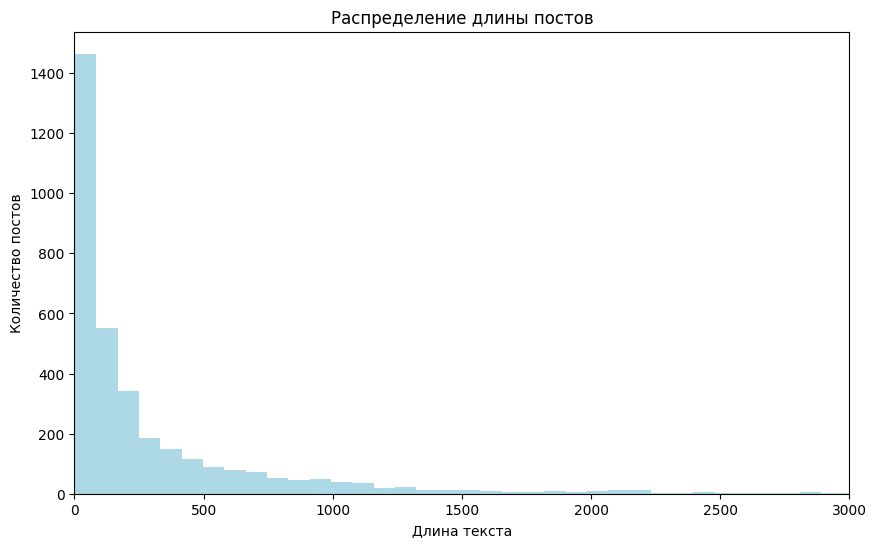

In [5]:
df['length'] = df['text'].str.len()
df['length'].describe()

plt.figure(figsize=(10,6))
plt.hist(df['length'], bins=100, color='lightblue')
plt.xlim(0, 3000)
plt.title('Распределение длины постов')
plt.xlabel('Длина текста')
plt.ylabel('Количество постов')
plt.show()

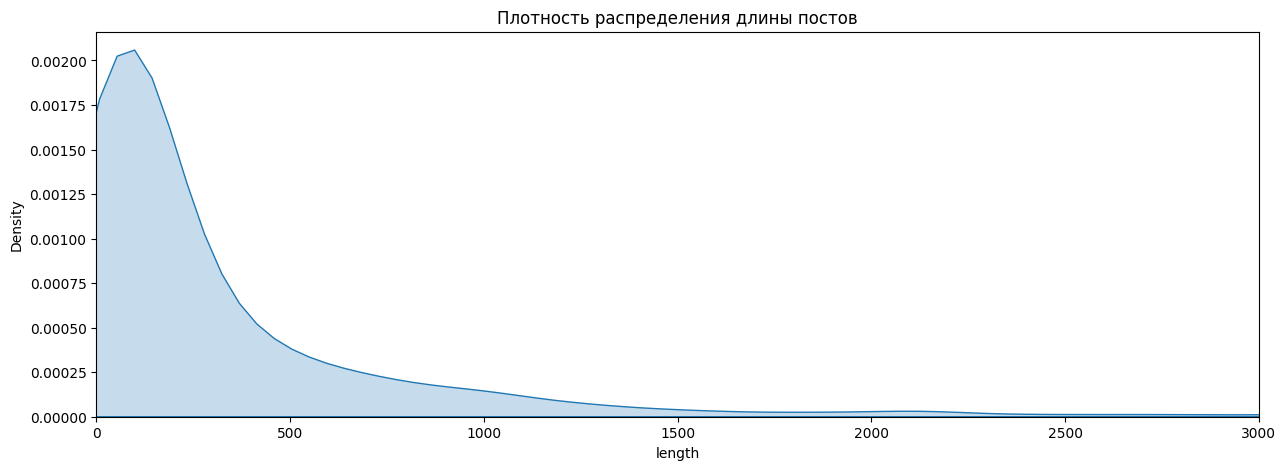

In [6]:
import seaborn as sns

plt.figure(figsize=(15,5))
sns.kdeplot(df['length'], fill=True)
plt.xlim(0, 3000)
plt.title('Плотность распределения длины постов')
plt.show()

In [7]:
#самые короткие посты
df.sort_values('length').head(10)

,text,length
318,😂😂😂,3
3506,🤣🤣🤣,3
2968,😍😍😍,3
3749,😱😱😱,3
230,РМРС,4
3943,Ушёл,4
3471,Порт,4
375,Мощь!,5
210,ОМик ❤,6
2150,212-ая,6


In [8]:
#топ-10 длинных постов
df[['text', 'length']].sort_values('length').head(10)
df[['text', 'length']].sort_values('length', ascending=False).head(10)

,text,length
4135,"🔥🔥🔥 Там, где вата облаков лижет золото песка,\...",8256
512,❗ В первую очередь хочу поблагодарить коллекти...,6385
1641,⚓ Здравствуйте коллеги! Затрону в этой статье ...,6226
1694,"🇷🇺 ""Операция Прорыв"". Как советские моряки спа...",6200
477,"Вода – источник жизни, но, к сожалению, многие...",5973
175,❗❄🌐Кто тайный бенефициар российской Арктики?\n...,5583
2348,Беломорско-Онежское пароходство. Герои и флот....,5519
2502,Как Россия и Норвегия делили Баренцево море\nБ...,5519
672,"23 июня 2025 года, четырёхмачтовому барку «Кру...",5005
3211,❓Будет ли мобилизация гражданского флота? Росс...,4963


###Обработка смайликов

Собираем смайлики для всех постов

In [9]:
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.EMOJI_DATA)

set_text = df['text'].astype(str).tolist()

#список строк где каждая строка — только смайлики из поста
emoji_chat = [extract_emojis(s) for s in set_text]

df['emojis'] = emoji_chat

Декодирование смайликов

In [10]:
def emojis_to_desc_en(emo_str: str) -> str:
    #emo_str строка типа '😊'
    if not emo_str:
        return ''
    dict_emoj = demoji.findall(emo_str)  #возвращает словарь типа {'😊': 'смайлинг фейс'}

    res = []
    for key in dict_emoj.keys():
        res.append(dict_emoj[key])

    #склеиваем описания в одну строку
    return ' '.join(res)

df['emoji_desc_en'] = df['emojis'].apply(emojis_to_desc_en)

df[df['emojis'] != ''][['text', 'emojis', 'emoji_desc_en']].head(10)

,text,emojis,emoji_desc_en
2,🔥 Танкер Virat вновь подвергся атаке беспилотн...,🔥,fire
3,❌️Причал КТК под Новороссийском атакованный бе...,❌,cross mark
6,🔥❌️⚓️Два танкера российского теневого флота бы...,🔥❌⚓,anchor cross mark fire
7,📢 Буксировка разводного пролета Большого Смоле...,📢,loudspeaker
9,❗️На строящемся Большом Смоленском мосту в Сан...,❗,red exclamation mark
10,▶Морской государственный университет имени адм...,▶,play button
12,"👍 19 ноября в Москве, на площадке выставки «Тр...",👍,thumbs up
14,«Капитан Геллер» проекта 170701 на ходовых исп...,😍,smiling face with heart-eyes
15,❗ВНИМАНИЕ СУДОВЛАДЕЛЬЦЕВ! ПРЕДЛАГАЕТСЯ К ПРОДА...,❗👨💼📲❗,mobile phone with arrow man red exclamation ma...
18,❗История жизни и загадочная смерть Рудольфа Ди...,❗,red exclamation mark


Перевод описания смайликов на русский

In [11]:
translator = Translator()

def translate_to_ru(text: str) -> str:
    text = text.strip()
    if not text:
        return ''
    try:
        result = translator.translate(text, dest='ru')
        return result.text
    except:
        #если гугл шлет ошибки оставляем англ варик
        return text

df['emoji_desc_ru'] = df['emoji_desc_en'].progress_apply(translate_to_ru)

  0%|          | 0/3477 [00:00<?, ?it/s]

Соединяем текст постов и перевод смайликов

In [12]:
df['text_with_emoji'] = df['text'] + ' ' + df['emoji_desc_ru'].fillna('')

##Предобработка текстов

In [13]:
morph = pymorphy3.MorphAnalyzer()
stop_ru = set(stopwords.words("russian"))
stop_en = set(stopwords.words("english"))

def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'#\S+', ' ', text)
    text = re.sub(r'\b(?:www\.)?\w+\.(?:ru|com|org|net|info|club|online|site|io|gov|edu)\b', ' ', text)
    text = re.sub(r"[^а-яА-ЯёЁa-zA-Z\s]", " ", text)
    text = text.lower()

    tokens = word_tokenize(text, language="russian")
    tokens = [w for w in tokens if w.isalpha()]

    #удаление стоп-слов, кроме "не"
    clean_tokens = []
    for w in tokens:
        if w == "не":
            clean_tokens.append(w)
            continue
        if w in stop_ru or w in stop_en:
            continue
        clean_tokens.append(w)

    lemmas = []
    for w in clean_tokens:
        if re.fullmatch(r"[а-яё]+", w):
            lemmas.append(morph.parse(w)[0].normal_form)
        elif re.fullmatch(r"[a-z]+", w):
            lemmas.append(w)
        else:
            continue

    lemmas = [w for w in lemmas if (len(w) > 1 or w == "не")]

    if lemmas:
        return " ".join(lemmas)

    #фолбэк
    text2 = re.sub(r"[^а-яА-ЯёЁa-zA-Z\s]", " ", text)
    out = " ".join([w for w in text2.split() if w.isalpha()])

    return out if out else ""

In [14]:
tqdm.pandas()
df['processed_text'] = df['text_with_emoji'].progress_apply(preprocess_text)

  0%|          | 0/3477 [00:00<?, ?it/s]

In [15]:
df[df['emojis'] != ''][['text', 'emojis', 'emoji_desc_ru', 'processed_text']].head()

,text,emojis,emoji_desc_ru,processed_text
2,🔥 Танкер Virat вновь подвергся атаке беспилотн...,🔥,огонь,танкер virat вновь подвергнуться атака беспило...
3,❌️Причал КТК под Новороссийском атакованный бе...,❌,крестик,причал ктк новороссийский атаковать безэкипажн...
6,🔥❌️⚓️Два танкера российского теневого флота бы...,🔥❌⚓,якорь крест знак огонь,танкер российский теневой флот атаковать берег...
7,📢 Буксировка разводного пролета Большого Смоле...,📢,громкоговоритель,буксировка разводный пролёт большой смоленский...
9,❗️На строящемся Большом Смоленском мосту в Сан...,❗,красный восклицательный знак,строиться большой смоленск мост санкт петербур...


##Описательная аналитика корпуса

Самые часто встречающиеся слова

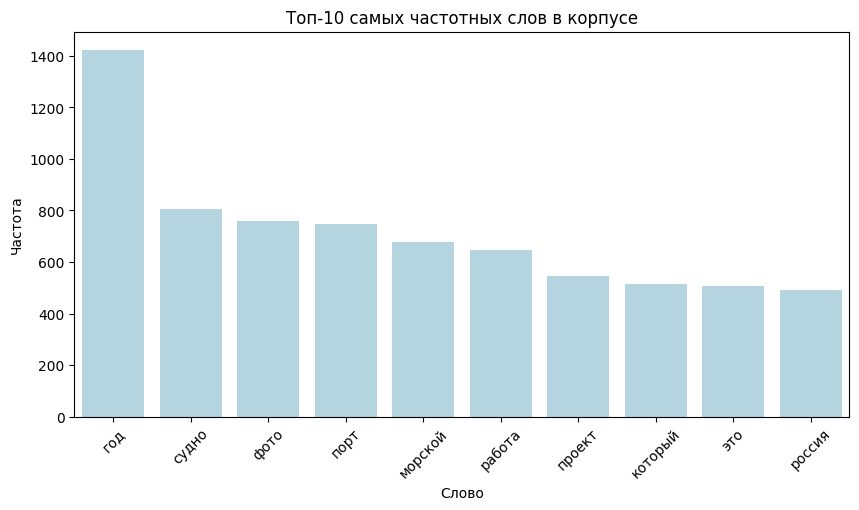

In [16]:
all_tokens = []

for text in df['processed_text']:
    tokens = re.findall(r'[а-яёa-z]+', str(text).lower())
    all_tokens.extend(tokens)

word_counts = Counter(all_tokens).most_common(50)
freq_df = pd.DataFrame(word_counts, columns=['слово', 'частота'])
freq_df = freq_df[freq_df['слово'] != 'не']  #чтобы "не" не забивало все

plt.figure(figsize=(10,5))
sns.barplot(data=freq_df.head(10), x='слово', y='частота', color = 'lightblue')
plt.title('Топ-10 самых частотных слов в корпусе')
plt.xlabel('Слово')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.show()

Облако слов

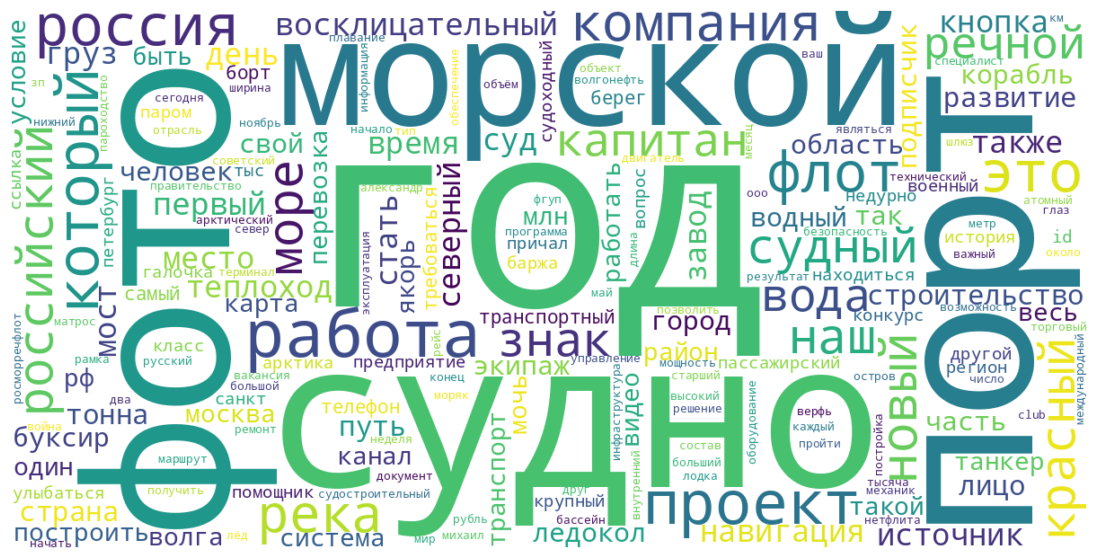

In [17]:
text_all = " ".join(df['processed_text'])

text_all = " ".join([w for w in all_tokens if w != 'не']) #опять же тк будет лишним

wc = WordCloud(width=1200, height=600, background_color='white', collocations=False).generate(text_all)

plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Самые частые биграммы

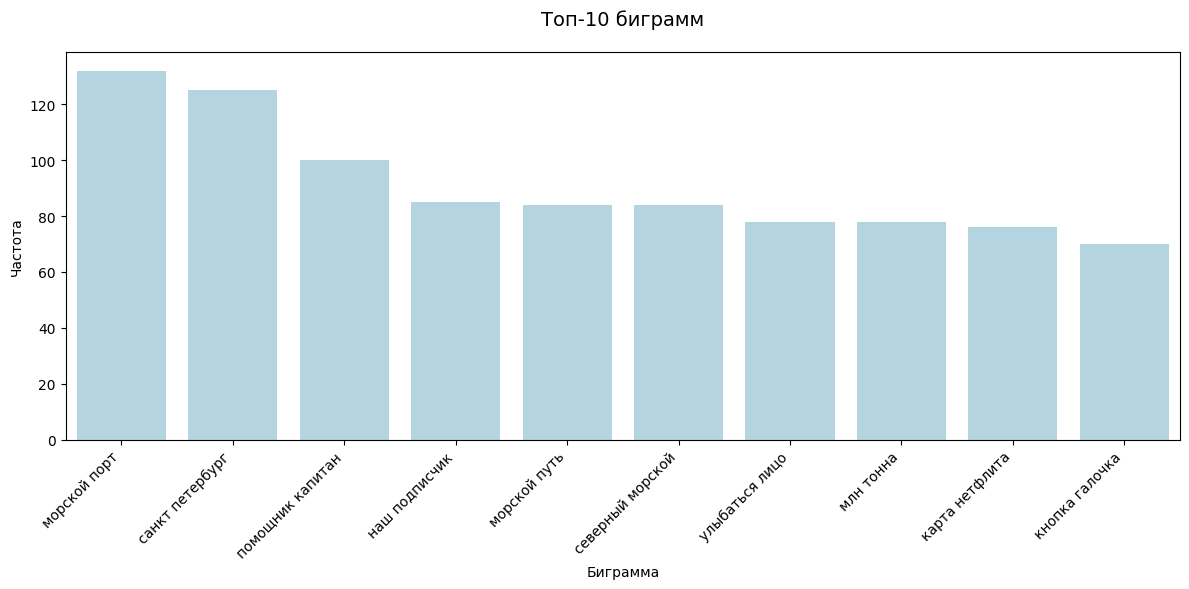

In [18]:
#считаем биграммы
vec = CountVectorizer(ngram_range=(2, 2), min_df=5)
X_bi = vec.fit_transform(df['processed_text'])

#суммируем частоты биграмм и собираем таблицу
bi_df = pd.DataFrame({
    'биграмма': vec.get_feature_names_out(),
    'частота': X_bi.toarray().sum(axis=0)
})

bi_df = bi_df.sort_values('частота', ascending=False).reset_index(drop=True)
bi_df = bi_df[~bi_df['биграмма'].str.contains('восклицательный|знак|красный')]

plt.figure(figsize=(12, 6))
sns.barplot(data=bi_df.head(10), x='биграмма', y='частота', color='lightblue')
plt.title('Топ-10 биграмм', fontsize=14, pad=20)
plt.xlabel('Биграмма')
plt.ylabel('Частота')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##Тональность с BERT

In [19]:
tqdm.pandas()

sentiment_model = pipeline("sentiment-analysis", model="seara/rubert-tiny2-russian-sentiment", return_all_scores=True)

THRESH = 0.45  #порог для positive/negative

def get_sentiment_thresh(text: str, thresh: float = THRESH) -> str:
    if not isinstance(text, str):
        text = str(text)
    text = text.strip()
    if not text:
        return "neutral"
    try:
        scores = sentiment_model(text)[0]   #список из dictов [{'label':..., 'score':...}, ...]
        #преобразуем в удобный вид: label -> score
        score_dict = {d['label'].lower(): d['score'] for d in scores}
        pos = score_dict.get('positive', 0.0)
        neg = score_dict.get('negative', 0.0)
        neu = score_dict.get('neutral', 0.0)

        #если positive или negative >= thresh — считаем это эмоцией
        #если оба выше порога — берём из них тот, что больше
        if pos >= thresh and neg < thresh:
            return 'positive'
        elif neg >= thresh and pos < thresh:
            return 'negative'
        elif pos >= thresh and neg >= thresh:
            #оба выше порога — берём более сильный
            return 'positive' if pos >= neg else 'negative'
        else:
            #ни позитив, ни негатив не дотянули — считаем нейтральным
            return 'neutral'

    except Exception:
        return "neutral"

df['sentiment'] = df['text_with_emoji'].progress_apply(get_sentiment_thresh)
df[['text', 'sentiment']].head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/3477 [00:00<?, ?it/s]

,text,sentiment
1,Наш поисковик для судоходной отрасли www.netfl...,neutral
2,🔥 Танкер Virat вновь подвергся атаке беспилотн...,neutral
3,❌️Причал КТК под Новороссийском атакованный бе...,neutral
4,"Храм-маяк Святителя Николая Чудотворца.\nКрым,...",neutral
5,Маяк «Анива» — заброшенное навигационное соору...,neutral


**Проверяем, что есть позитивные и негативные посты**

In [20]:
df['sentiment'].value_counts(), df['sentiment'].value_counts(normalize=True).round(3)

(sentiment
 neutral     2739
 positive     581
 negative     157
 Name: count, dtype: int64,
 sentiment
 neutral     0.788
 positive    0.167
 negative    0.045
 Name: proportion, dtype: float64)

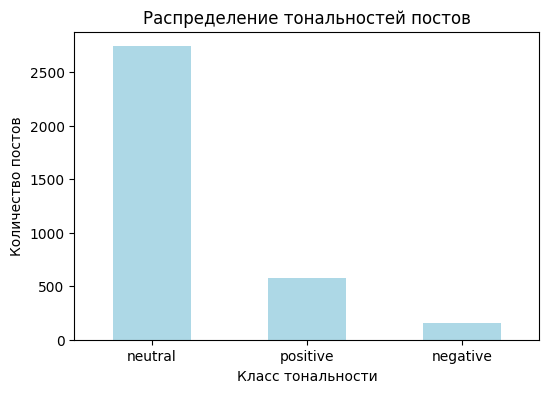

In [21]:
sent_counts = df['sentiment'].value_counts()

plt.figure(figsize=(6,4))
sent_counts.plot(kind='bar', color = 'lightblue')
plt.title('Распределение тональностей постов')
plt.xlabel('Класс тональности')
plt.ylabel('Количество постов')
plt.xticks(rotation=0)
plt.show()

##Обучение моделей

###LogisticRegression с оверсэмплингом

In [22]:
VOCABULARY_SIZE = 10000

X = df['processed_text']
y = df['sentiment']

#общий train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Распределение классов в исходном train:")
print(y_train.value_counts())

#оверсэмплинг
train_df = pd.DataFrame({'text': X_train, 'sentiment': y_train})

neu = train_df[train_df['sentiment'] == 'neutral']
pos = train_df[train_df['sentiment'] == 'positive']
neg = train_df[train_df['sentiment'] == 'negative']

#целевой размер - нейтралка
target_per_class = len(neu)

pos_up = pos.sample(target_per_class, replace=True, random_state=42)
neg_up = neg.sample(target_per_class, replace=True, random_state=42)

train_balanced = pd.concat([neu, pos_up, neg_up]) \
    .sample(frac=1, random_state=42) \
    .reset_index(drop=True)

print("\nРаспределение классов в upsampled train:")
print(train_balanced['sentiment'].value_counts())

#общий tf-idf
tfidf_vectorizer = TfidfVectorizer(max_features=VOCABULARY_SIZE, ngram_range=(1, 2))

#признаки для логрег
X_train_tfidf_up = tfidf_vectorizer.fit_transform(train_balanced['text'])

#признаки для теста
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#признаки для ИСХОДНОГО несбалансированного train для нн
X_train_tfidf = tfidf_vectorizer.transform(X_train)

print("\nРазмерность TF-IDF матрицы train (upsampled):", X_train_tfidf_up.shape)

logreg_up = LogisticRegression(max_iter=1000)
logreg_up.fit(X_train_tfidf_up, train_balanced['sentiment'])

y_pred_up = logreg_up.predict(X_test_tfidf)

labels = ['negative', 'neutral', 'positive']

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test,
    y_pred_up,
    average=None,
    labels=labels,
    zero_division=0
)
accuracy = accuracy_score(y_test, y_pred_up)

print(f"\nAccuracy (logreg + oversampling): {accuracy:.4f}")

metrics_logreg = pd.DataFrame({
    'class': labels,
    'precision': precision,
    'recall': recall,
    'f1': f1
})
metrics_logreg

Распределение классов в исходном train:
sentiment
neutral     2191
positive     465
negative     125
Name: count, dtype: int64

Распределение классов в upsampled train:
sentiment
neutral     2191
positive    2191
negative    2191
Name: count, dtype: int64

Размерность TF-IDF матрицы train (upsampled): (6573, 10000)

Accuracy (logreg + oversampling): 0.7802


,class,precision,recall,f1
0,negative,0.281250,0.281250,0.281250
1,neutral,0.880539,0.833942,0.856607
2,positive,0.531034,0.663793,0.590038


Посмотрим какие ошибки допустила моделька

In [23]:
from sklearn.metrics import confusion_matrix

cm_logreg = confusion_matrix(y_test, y_pred_up, labels=labels)

cm_logreg_df = pd.DataFrame(
    cm_logreg,
    index=[f"true_{lbl}" for lbl in labels],
    columns=[f"pred_{lbl}" for lbl in labels]
)

print("\nМатрица ошибок (логистическая регрессия):")
print(cm_logreg_df)

logreg_errors = (y_test.values != y_pred_up).sum()
print("\nКоличество ошибок (логистическая регрессия):", logreg_errors)


Матрица ошибок (логистическая регрессия):
               pred_negative  pred_neutral  pred_positive
true_negative              9            23              0
true_neutral              23           457             68
true_positive              0            39             77

Количество ошибок (логистическая регрессия): 153


###MLP+oversampling

In [24]:
le = LabelEncoder()
le.fit(y)

#кодируем train/test метки
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

print(X_train_tfidf.shape, X_test_tfidf.shape)
print(pd.Series(y_train_enc).value_counts())

ros = RandomOverSampler(random_state=42)
X_train_over, y_train_over = ros.fit_resample(X_train_tfidf, y_train_enc)

print("Форма после oversampling:", X_train_over.shape)
print(pd.Series(y_train_over).value_counts())

X_train_over_dense = X_train_over.astype('float32').toarray()
X_test_dense = X_test_tfidf.astype('float32').toarray()

num_features = X_train_over_dense.shape[1]
num_classes = len(le.classes_)

print(num_features, num_classes)
tf.random.set_seed(42)

nn_model = Sequential([
    Dense(256, activation='relu', input_shape=(num_features,)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

nn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

nn_model.summary()

history = nn_model.fit(
    X_train_over_dense,
    y_train_over,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=2
)

y_pred_proba = nn_model.predict(X_test_dense)
y_pred_nn = y_pred_proba.argmax(axis=1)

print("Accuracy (NN + oversampling):", accuracy_score(y_test_enc, y_pred_nn), 4)

print(classification_report(
    y_test_enc,
    y_pred_nn,
    target_names=le.classes_,
    digits=4
))

(2781, 10000) (696, 10000)
1    2191
2     465
0     125
Name: count, dtype: int64
Форма после oversampling: (6573, 10000)
2    2191
1    2191
0    2191
Name: count, dtype: int64
10000 3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     2,560,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,539 (9.89 MB)

 Trainable params: 2,593,539 (9.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
83/83 - 5s - 62ms/step - accuracy: 0.7259 - loss: 0.6795 - val_accuracy: 0.0160 - val_loss: 1.1395
Epoch 2/10
83/83 - 4s - 49ms/step - accuracy: 0.9011 - loss: 0.2394 - val_accuracy: 0.8449 - val_loss: 0.4105
Epoch 3/10
83/83 - 3s - 42ms/step - accuracy: 0.9526 - loss: 0.1247 - val_accuracy: 0.9209 - val_loss: 0.2120
Epoch 4/10
83/83 - 6s - 66ms/step - accuracy: 0.9743 - loss: 0.0780 - val_accuracy: 0.9445 - val_loss: 0.1503
Epoch 5/10
83/83 - 4s - 47ms/step - accuracy: 0.9829 - loss: 0.0516 - val_accuracy: 0.9817 - val_loss: 0.0591
Epoch 6/10
83/83 - 3s - 40ms/step - accuracy: 0.9882 - loss: 0.0367 - val_accuracy: 0.9901 - val_loss: 0.0544
Epoch 7/10
83/83 - 6s - 71ms/step - accuracy: 0.9916 - loss: 0.0291 - val_accuracy: 0.9856 - val_loss: 0.0503
Epoch 8/10
83/83 - 4s - 43ms/step - accuracy: 0.9926 - loss: 0.0231 - val_accuracy: 0.9802 - val_loss: 0.0639
Epoch 9/10
83/83 - 3s - 41ms/step - accuracy: 0.9949 - loss: 0.0193 - val_accuracy: 0.9886 - val_loss: 0.0295
Epoch 10/1

Посмотрим какие ошибки допустила модель

In [25]:
cm_nn = confusion_matrix(y_test_enc, y_pred_nn)

cm_nn_df = pd.DataFrame(
    cm_nn,
    index=[f"true_{lbl}" for lbl in le.classes_],
    columns=[f"pred_{lbl}" for lbl in le.classes_]
)

print("\nМатрица ошибок (нейронная сеть):")
print(cm_nn_df)

#кол-во ошибок
nn_errors = (y_test_enc != y_pred_nn).sum()
print("\nКоличество ошибок (нейронная сеть):", nn_errors)


Матрица ошибок (нейронная сеть):
               pred_negative  pred_neutral  pred_positive
true_negative              1            31              0
true_neutral               3           510             35
true_positive              0            68             48

Количество ошибок (нейронная сеть): 137
